## overview

In [1]:
# default package
import logging
import sys 
import os
import pathlib
import IPython
import random
from urllib.request import urlretrieve
import dataclasses as dc

In [2]:
# third party package
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import seaborn as sns
import yaml
# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

In [3]:
# my package
sys.path.append(os.path.join(pathlib.Path().resolve(),"../"))
import src.model.dcgan as dcgan
import src.dataset.generate_pathlist as gp
import src.dataset.image_dataset as dataset
import src.model.image_generate as ig

In [4]:
# reload settings
%load_ext autoreload
%autoreload 2

In [5]:
# logger
logger=logging.getLogger(__name__)
logging.basicConfig(level=logging.ERROR)

In [6]:
# graph setting
sns.set()

In [7]:
# gpu
torch.cuda.is_available()
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## anomaly detection

### model

In [8]:
with open("../config/config.yml") as f:
    config=yaml.load(f,Loader=yaml.SafeLoader)
config=ig.Config(**config)

discriminator=dcgan.Discriminator()
generator=dcgan.Generator()
criterion=nn.BCEWithLogitsLoss(reduction="mean")
model = ig.GAN(
        discriminator=discriminator,
        generator=generator,
        criterion=criterion,
        **dc.asdict(config),
        )

In [9]:
model=model.load_from_checkpoint(checkpoint_path="../logs/lightning/2021-03-12-10-21-42_9bbbd4ec28744fb3a0acd44931bc8357-v0.ckpt")

In [10]:
model=model.to(device)

### data

In [11]:
batch_size=2

In [12]:
path_list=gp.make_datapath_list("../data/test/")

In [13]:
test_dataset=dataset.ImageDataset(path_list,dataset.BaseTransform())

In [44]:
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=True,drop_last=True)

In [45]:
for imgs in test_loader:
    pass

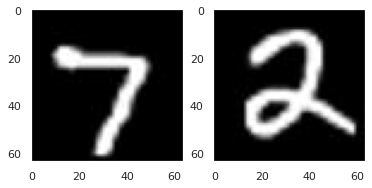

In [46]:
fig,axes=plt.subplots(1,batch_size,squeeze=False)
for i in range(batch_size):
    axes[0,i].imshow(imgs[i].permute(1,2,0),cmap="gray")
    axes[0,i].grid(False)

In [47]:
imgs=imgs.to(device)

### anomaly

In [48]:
def Anomaly_score(x, fake_img, D, Lambda=0.1):

    # テスト画像xと生成画像fake_imgのピクセルレベルの差の絶対値を求めて、ミニバッチごとに和を求める
    residual_loss = torch.abs(x-fake_img)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)

    # テスト画像xと生成画像fake_imgを識別器Dに入力し、特徴量を取り出す
    _, x_feature = D(x)
    _, G_feature = D(fake_img)

    # テスト画像xと生成画像fake_imgの特徴量の差の絶対値を求めて、ミニバッチごとに和を求める
    discrimination_loss = torch.abs(x_feature-G_feature)
    discrimination_loss = discrimination_loss.view(
        discrimination_loss.size()[0], -1)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)

    # ミニバッチごとに2種類の損失を足し算する
    loss_each = (1-Lambda)*residual_loss + Lambda*discrimination_loss

    # ミニバッチ全部の損失を求める
    total_loss = torch.sum(loss_each)

    return total_loss, loss_each, residual_loss

### get z

In [49]:
max_epochs=5000

In [50]:
z=torch.randn(batch_size,20,1,1).to(device)

In [51]:
z.requires_grad=True

In [52]:
optimizer=optim.Adam([z],lr=1e-3)

In [53]:
for epoch in tqdm(range(max_epochs)):
    fake_img=model.generator(z)
    loss, _, _ = Anomaly_score(imgs, fake_img, model.discriminator, Lambda=0.1)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch%1000==0: print(loss)

  0%|          | 3/5000 [00:00<04:18, 19.35it/s]

tensor(2744.7812, device='cuda:0', grad_fn=<SumBackward0>)


 20%|██        | 1007/5000 [00:35<01:54, 34.73it/s]

tensor(1589.6775, device='cuda:0', grad_fn=<SumBackward0>)


 40%|████      | 2006/5000 [01:10<01:45, 28.51it/s]

tensor(1234.7026, device='cuda:0', grad_fn=<SumBackward0>)


 60%|██████    | 3004/5000 [01:47<01:43, 19.30it/s]

tensor(1041.9998, device='cuda:0', grad_fn=<SumBackward0>)


 80%|████████  | 4005/5000 [02:21<00:30, 32.64it/s]

tensor(996.7673, device='cuda:0', grad_fn=<SumBackward0>)


100%|██████████| 5000/5000 [02:54<00:00, 28.71it/s]


total loss： [214. 734.]


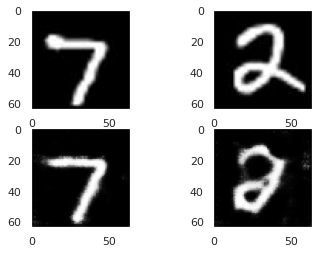

In [56]:
# 画像を生成
model.generator.eval()
fake_img = model.generator(z)

# 損失を求める
loss, loss_each, residual_loss_each = Anomaly_score(
    imgs, fake_img, model.discriminator, Lambda=0.1)

# 損失の計算。トータルの損失
loss_each = loss_each.cpu().detach().numpy()
print("total loss：", np.round(loss_each, 0))

fig,axes=plt.subplots(2,batch_size,squeeze=False)
for i in range(batch_size):
    axes[0,i].imshow(imgs[i].cpu().detach().permute(1,2,0),cmap="gray")
    axes[1,i].imshow(fake_img[i].cpu().detach().permute(1,2,0),cmap="gray")
    axes[0,i].grid(False)
    axes[1,i].grid(False)

In [62]:
import pytz
import datetime

In [63]:
now = datetime.datetime.now(pytz.timezone('Asia/Tokyo'))

In [64]:
now

datetime.datetime(2021, 3, 13, 1, 56, 50, 978694, tzinfo=<DstTzInfo 'Asia/Tokyo' JST+9:00:00 STD>)

In [65]:
import dataclasses as dc
@dc.dataclass
class Config:
    """設定値"""
    # GAN
    image_size:int=64

In [66]:
config=Config()

In [68]:
import glob

In [71]:
glob.glob("../config/*")[0]

'../config/config.yml'